# Atividade 6 - Redução de Dimensionalidade para Classificação via PCA

Nome: Juan Felipe Da Silva Rangel

O objetivo desta atividade é explorar o dataset 'dota2DatasetTrain_header_01.csv', que contém 9264 partidas de Dota 2, nas quais os heróis que participaram de um time são atribuídos os valores 1, e os do time contrário, o valor -1, além também do resultado da partida.
 Nesta atividade devemos utilizar classificadores SVM, KNN e RandomForest para predizer qual dos dois times seria o vencedor. Como a maioria dos dados são zeros, dizemos que esse é um dataset esparço. Será necessário então testar os classificadores acimas, otimizando os hiperparâmetros que já foram vistos, sem realizar a diminuição de dimensionalidade e realizando o PCA, comparando em seguida os resultados obtidos.

In [38]:
import pandas as pd
import numpy as np
import functools
import seaborn as sns

import utils
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import functools

from joblib import Parallel, delayed


# Carregando Dataset Video_game_esrb_rating.csv

In [39]:
df = pd.read_csv('dota2DatasetTrain_header_01.csv')
df.tail()

,cluster_id,game_mode,game_type,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,...,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111,hero_112,winning_team
9259,223,2,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,-1
9260,225,2,2,0,0,0,0,0,-1,0,...,0,0,-1,0,0,0,0,0,0,1
9261,227,2,2,0,0,0,0,0,1,-1,...,0,0,0,0,0,1,0,0,0,1
9262,156,2,3,-1,-1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
9263,138,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Abaixo separei as classes e seus atributos para que seja possível então realizar o PCA para essa base de dados.

In [40]:
# derrubo a coluna com os times vencedores e atribuo para y
X = df.drop('winning_team', axis=1)
y = df['winning_team'].values

X.head()

,cluster_id,game_mode,game_type,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,...,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111,hero_112
0,156,2,2,0,0,0,-1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,204,2,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,-1,0,0,0
2,227,8,3,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,153,2,3,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,153,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Realizando PCA
Para diminuição de dimensionalidade foi aplicado o método PCA, utilizando o número de componentes (ou seja, a quantidade de colunas) como 2 (PC0, PC1).

In [41]:
pca = PCA(n_components=2)

pca.fit(X)


X_pca = pca.transform(X)

X_pca_df = pd.DataFrame(X_pca, columns=['PC0', 'PC1'])

X_pca_df.head() 

,PC0,PC1
0,-20.229013,-1.061209
1,27.766559,-1.698290
2,50.844586,3.970736
3,-23.228815,-1.041301
4,-23.228674,-1.040402


# Visualizando espaço formado de características após realizar o PCA com duas dimensões

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

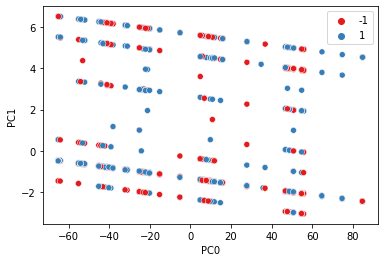

In [42]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue=y, palette='Set1')

# Treina e Seleciona o melhor modelo
Em seguida é possível observar as funções que são utilizadas para treinar os classificadores, especificamente para realizar o treinamento no segundo nível, o qual, para esta atividade, foi feito em 5 vias. Também é feito o uso do parâmetro scoring do módulo GridSearchCV para escolher a melhor métrica de desempenho (utilizando o weighted f1-score).

In [58]:
def selecionar_melhor_modelo(classificador, X_treino, X_val, y_treino, 
                             y_val, n_jobs=4, 
                             cv_folds=None, params={}):
    
    def treinar_modelo(X_treino, X_val, y_treino, y_val, params):
        clf = classificador(**params)
        clf.fit(X_treino, y_treino)
        pred = clf.predict(X_val)
        
        if len(set(y_treino)) > 2:
            return f1_score(y_val, pred, average='weighted')
        else:
            return f1_score(y_val, pred)
    
    
    if cv_folds is not None:
        #Se for pra usar validação cruzada, usar GridSearchCV
        score_fn = 'f1' if len(set(y_treino)) < 3 else 'f1_weighted'
        
        clf = GridSearchCV(classificador(), params, cv=cv_folds, n_jobs=n_jobs, scoring=score_fn)
        #Passar todos os dados (Treino e Validação) para realizar a seleção dos parâmetros.
        clf.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        
        melhor_comb = clf.best_params_
        melhor_val = clf.best_score_
        
    else:
        param_grid = list(ParameterGrid(params))
        
        f1s_val = Parallel(n_jobs=n_jobs)(delayed(treinar_modelo)
                                         (X_treino, X_val, y_treino, y_val, p) for p in param_grid)

        melhor_val = max(f1s_val)
        melhor_comb = param_grid[np.argmax(f1s_val)]
        
        clf = classificador(**melhor_comb)
        
        clf.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return clf, melhor_comb, melhor_val

# Função Genérica para realizar Cross-Validation
Abaixo foi utilizada uma função genérica para realizar o Cross-Validation, a qual permite passar por parâmetro o classificador que será utilizado, a quantidade de splits e folds, os parâmetros que serão otimizados e se deverá ser realizado ou não a normalização dos splits.

In [44]:
def do_cv(classificador, X, y, cv_splits, param_cv_folds=None, n_jobs=8, scale=False, imputer=None, dim_red=None, params={}):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    f1s = []
    list_confusion_matrix = []
    list_melhor_comb = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        if isinstance(X, pd.DataFrame):
            X_treino = X.iloc[treino_idx]
            X_teste = X.iloc[teste_idx]
            
            if imputer is not None:
                X_treino = imputer.fit_transform(X_treino)
                X_teste = imputer.transform(X_teste)
            else:
                X_treino = X_treino.values
                X_teste = X_teste.values   
            
        else:
            X_treino = X[treino_idx]
            X_teste = X[teste_idx]
            
        y_treino = y[treino_idx]
        y_teste = y[teste_idx]        

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)
        
        if imputer is not None:
            X_val = imputer.transform(pd.DataFrame(X_val, columns=X.columns))
        
        if scale:
            ss = StandardScaler()
            X_treino = ss.fit_transform(X_treino)
            X_teste = ss.transform(X_teste)
            X_val = ss.transform(X_val)
            
        if dim_red is not None:
            X_treino = dim_red.fit_transform(X_treino)
            X_teste = dim_red.transform(X_teste)
            X_val = dim_red.transform(X_val)
            
        ad, melhor_comb, _ = selecionar_melhor_modelo(classificador, X_treino, X_val, y_treino, y_val, 
                                                      n_jobs=n_jobs, cv_folds=param_cv_folds, params=params)
        pred = ad.predict(X_teste)

        if len(set(y_treino)) > 2:
            f1 = f1_score(y_teste, pred, average='weighted')
        else:
            f1 = f1_score(y_teste, pred)
        f1s.append(f1)

        print(f'{melhor_comb} -- F1-Score: {f1}')
        list_melhor_comb.append(melhor_comb)

        list_confusion_matrix.append(confusion_matrix(y_teste, pred))
        
        pgb.update(1)
        
    pgb.close()
    
    return f1s, list_confusion_matrix, list_melhor_comb

# KNN

In [45]:
# Avaliando o desempenho do KNN
result_classifiers ={}

ks = list(range(1,30,2))
# knn, list_confusion_matrix_knn, list_melhor_comb = do_cv(KNeighborsClassifier,X.values, y, 10, 5, 2, True, {'n_neighbors' : range(1,30,2)})
knn, list_confusion_matrix_knn, list_melhor_comb = do_cv(KNeighborsClassifier, X, y, 10, 5, 8, False, None, None, {'n_neighbors' : ks})
# (classificador, X, y, cv_splits, param_cv_folds=None, n_jobs=8, scale=False, imputer=None, dim_red=None, params={})

result_classifiers['knn'] = knn

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

{'n_neighbors': 25} -- F1-Score: 0.585603112840467
{'n_neighbors': 29} -- F1-Score: 0.5791505791505791
{'n_neighbors': 29} -- F1-Score: 0.6013071895424837
{'n_neighbors': 29} -- F1-Score: 0.598690364826941
{'n_neighbors': 29} -- F1-Score: 0.5736738703339882
{'n_neighbors': 27} -- F1-Score: 0.5764362220058423
{'n_neighbors': 25} -- F1-Score: 0.6101694915254237
{'n_neighbors': 25} -- F1-Score: 0.5874524714828897
{'n_neighbors': 27} -- F1-Score: 0.6065727699530518
{'n_neighbors': 29} -- F1-Score: 0.5939629990262901


# result_classifiers do KNN

In [46]:
utils.imprimir_estatisticas(knn)

Resultados: 0.59 +- 0.01, min: 0.57, max: 0.61


Realizo a visualização das somas das matrizes de confusão obtidas ao executar o KNN.

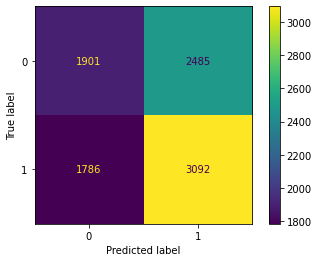

In [47]:
reduceMatrix = functools.reduce(lambda x,y :  x + y, list_confusion_matrix_knn)

disp = ConfusionMatrixDisplay(confusion_matrix=reduceMatrix)
disp.plot()

# SVM

In [48]:
# Avaliando o desempenho do SVM
svm, list_confusion_matrix_svm, list_melhor_comb = do_cv(SVC,  X, y, 10, 5, 2, False, None, None, {'gamma' : ['auto', 'scale'],
                'C' : [1, 10, 100, 1000], 'kernel': ['rbf']})

result_classifiers['svm'] = svm

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.6897526501766785
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.6897526501766785
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.6897526501766785
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.6897526501766785
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.6902404526166902
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.6902404526166902
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.6902404526166902
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.6902404526166902
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.689313517338995
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.689313517338995


# result_classifiers SVM

In [49]:
utils.imprimir_estatisticas(svm)

Resultados: 0.69 +- 0.00, min: 0.69, max: 0.69


Realizo a visualização das somas das matrizes de confusão obtidas ao executar o SVM.

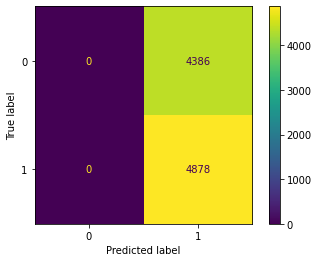

In [50]:
reduce_matrix_svm = functools.reduce(lambda x,y :  x + y, list_confusion_matrix_svm)

disp_svm = ConfusionMatrixDisplay(confusion_matrix=reduce_matrix_svm)
disp_svm.plot()

# Random Forest

In [51]:
# Avaliando o desempenho do Random Forest
random_forest, list_confusion_matrix_rf, list_melhor_comb = do_cv(RandomForestClassifier, X, y, 10, 5, 2, False, None, None, {'criterion' : ['gini', 'entropy'], 'random_state' : [1]})
result_classifiers['randomFor'] = random_forest

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

{'criterion': 'entropy', 'random_state': 1} -- F1-Score: 0.5994065281899109
{'criterion': 'entropy', 'random_state': 1} -- F1-Score: 0.5703048180924287
{'criterion': 'gini', 'random_state': 1} -- F1-Score: 0.6280373831775701
{'criterion': 'entropy', 'random_state': 1} -- F1-Score: 0.5938104448742746
{'criterion': 'gini', 'random_state': 1} -- F1-Score: 0.5984405458089669
{'criterion': 'entropy', 'random_state': 1} -- F1-Score: 0.5688622754491018
{'criterion': 'gini', 'random_state': 1} -- F1-Score: 0.5880077369439072
{'criterion': 'entropy', 'random_state': 1} -- F1-Score: 0.6048780487804878
{'criterion': 'gini', 'random_state': 1} -- F1-Score: 0.6165703275529866
{'criterion': 'entropy', 'random_state': 1} -- F1-Score: 0.5824493731918997


In [52]:
utils.imprimir_estatisticas(random_forest)

Resultados: 0.60 +- 0.02, min: 0.57, max: 0.63


Realizo a visualização das somas das matrizes de confusão obtidas ao executar o Random Forest.

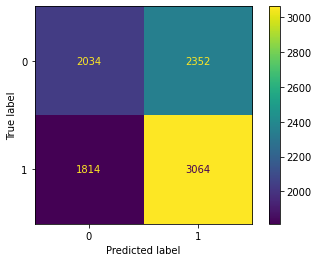

In [53]:
reduce_matrix_rf = functools.reduce(lambda x,y :  x + y, list_confusion_matrix_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=reduce_matrix_rf)
disp_rf.plot()

# Testando KNN, SVM e Random Forest com PCA (2, 8, 16, 32 e 64 dimensões)

Testa para todos os classificador utilizando diferentes valores para o tamanho da dimensão no PCA. Neste caso serão testados 5 valores de dimensões diferentes, sendo eles: 2 dimensões, 8, 16, 32 e 64 dimensões.

In [57]:
qtd_dimensions_pca = [2,8,16,32,64]

knn_classifier = ('knn', KNeighborsClassifier, True, {'n_neighbors' : range(1,30,2)})

svm_classifier = ('svm', SVC, True, {'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale']})

random_forest = ('rf', RandomForestClassifier, False, {'criterion' : ['gini', 'entropy'], 'random_state' : [1]})

classifiers = [knn_classifier, svm_classifier, random_forest]

for dimension in qtd_dimensions_pca:
    pca = PCA(n_components=dimension)
    print(dimension)
    for name_classifier, classifier_class, scale, params in classifiers:
        # X.values, y, 10, 5, 2, False, None, None, 
        result = do_cv(classifier_class, X, y, 10, 5, 2, scale, None, pca, params)
        result_classifiers[name_classifier + '_' + str(dimension)] = result


2


Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Shape of passed values is (1668, 2), indices imply (1668, 116)

# Resultados de todos os testes
Imprime os resultados de todos os testes realizados.

In [ ]:
for result in sorted(result_classifiers):
    print(result.rjust(10, end= ' - '))
    utils.imprimir_estatisticas(result_classifiers[result])

# Teste-T
Realiza o teste-t entre todos os resultados obtidos com e sem redução de dimensionalidade.

In [ ]:
utils.print_t_tests(result_classifiers, cols=['knn', 'rf', 'svm'])

# Discussão dos result_classifiers

OBS: Resultados ainda serão adicionados